# Detection Accuracy
### Privacy Advocates, EECS504 F20
Thomas Cope, Sean Higgins, John Gearig, James Wegienka  <br />
Updated: 12 Dec 20

In [251]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [270]:
def get_data(group, path):
    '''
    Creates a list of tuples, each with an image name and its bounding box statistics.
    Input: 
        group: what picture group we want, e.g. couples
        path: path to the wider_faces_train_bbx_gt.txt
    Output: 
        data: list of tuples of data (filename, bbs (list itself))
    '''
    # Based on https://towardsdatascience.com/how-do-you-train-a-face-detection-model-a60330f15fd5
    
    f = open(path, 'r')
    file = f.readlines()
    data = []
    count = 0

    for i in file:
        # Grab the files for specific group
        if group in i:
            
            # image name and remove \n
            filename = file[count]
            filename = filename[:-1]

            # get bounding boxes
            numFaces = int(file[count + 1])
            bbsStart = count + 2
            boxes = []
            
            occ = 0
            for j in range(0, numFaces):
                face = file[bbsStart + j]
                bbs = face.split(' ')
                occ = max(occ,int(bbs[8]))
                bbs = bbs[:4]
                bbs = [int(k) for k in bbs]
                boxes.append(bbs)

            # Create a tuple with file name and list of bounding boxes, and save
            if occ != 0:
                pass
            else:
                temp = (filename, boxes)
                data.append(temp)

        count += 1
    return data


In [253]:
def min_dist(x, y, boxes):
    '''
    Finding the nearest bounding box (if not in order)
    Input:
        x: detected starting x
        y: detected starting y
        boxes: list of all the bounding boxes for the image
    '''
    mindist = 999999999 #arbitrary large number
    
    for k in range(0, len(boxes)):
        x1 = boxes[k][0]
        y1 = boxes[k][1]
        dist = np.sqrt((x1 - x) ** 2 + (y1 - x) ** 2) #Euclidean distance
        if dist < mindist:
            mindist = dist
            mink = k
    
    return mink

## Runs the comparison of the two different types of classification

In [254]:
def tester(data, prototxtPath, weightsPath):
    '''
    Tests the accuracy of the classifier vs. the ground truth.
    Input:
        data: tuple of (filename, bbs(list itself)), which is the output of get_data()
        prototxtPath: path to prototext file (used for DNN architecture)
        weightsPath: path to caffe file (used for DNN architecture)
    Output: 
        total: tuple of (filename, average accuracy per face, count of faces)
    '''
    
    #Defining DNN (baseline classifier)
    net = cv2.dnn.readNet(prototxtPath, weightsPath)
    
    total = []
    
    #For each image
    for i in range(0,len(data)):

        # load the input image from disk, and grab the image spatial dimensions
        image = cv2.imread(data[i][0], cv2.IMREAD_COLOR)
        (h, w) = image.shape[:2]

        # construct a blob from the image
        blob = cv2.dnn.blobFromImage(image, 1.0, (300, 300), (104.0, 177.0, 123.0))

        # pass the blob through the network and obtain the face detections
        net.setInput(blob)
        detections = net.forward()
        boxes = data[i][1]
        num_faces = len(boxes)
        count = 0
        result = []
        
        # loop over the detections
        for j in range(0, detections.shape[2]):
            
            # extract the confidence (i.e., probability) associated with the detection
            confidence = detections[0, 0, j, 2]

            # filter out weak detections by ensuring the confidence is greater than the minimum confidence
            if confidence > 0.3:

                count += 1  # keep track of found faces

                # compute the (x, y)-coordinates of the bounding box for the object
                box = detections[0, 0, j, 3:7] * np.array([w, h, w, h])
                (startX, startY, endX, endY) = box.astype("int")

                mink = min_dist(startX, startY, boxes)

                known = (boxes[mink][0], boxes[mink][1], boxes[mink][0] + boxes[mink][2], boxes[mink][1] + boxes[mink][3])
                found = (startX, startY, endX, endY)

                result.append(get_iou(known, found))

        # for each image, get: name, avg, actual number of faces, count
        out = (data[i][0], result, num_faces, count)
        total.append(out)

    return total

## Finding the intersection over the union - a standard method for measuring accuracy of the bounding boxes

According to https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/. Apparently, we are looking for a value over 0.5

In [255]:
def get_iou(bb1, bb2):
    """
    https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Or: bb1 is a tuple with data (x1, y1, x2, y2)
        bb2 is a tuple with data (x1, y1, x2, y2)

    Returns
    -------
    float
        in [0, 1]
    """
    # determine the coordinates of the intersection rectangle

    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

# Dataset: Couple
## Collecting data from txt file

In [271]:
group = "Couple"
path = "/Users/thomcope/Documents/ACADEMICS/20 Fall/EECS504/wider_face_split/wider_face_train_bbx_gt.txt" 
data = get_data(group, path)

## Where its calculated

In [272]:
prototxtPath = "/Users/thomcope/Documents/ACADEMICS/20 Fall/EECS504/deploy.prototxt"
weightsPath = "/Users/thomcope/Documents/ACADEMICS/20 Fall/EECS504/res10_300x300_ssd_iter_140000.caffemodel"
result = tester(data, prototxtPath, weightsPath)

## Display the results

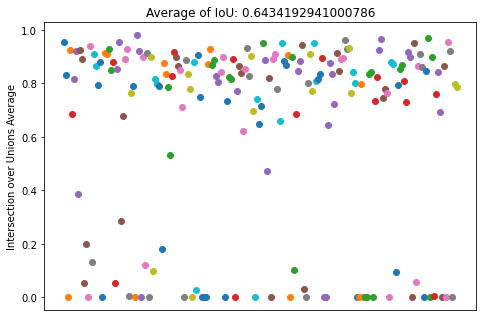

In [273]:
acc = []
for i in range(0, len(result)):
    acc.extend(result[i][1])

acc_arr = np.array(acc)
avg_acc = np.mean(acc_arr)

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

idx = 0
for i in range(0,len(result)):
    ar = result[i][1] 
    plt.scatter( range(idx, idx+len(ar)) , ar)
    idx = idx + len(ar)



ax.set_title('Average of IoU: {}'.format(avg_acc))
ax.set_ylabel('Intersection over Unions Average')  
ax.axes.xaxis.set_visible(False)
plt.show()

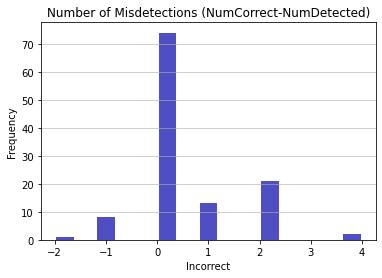

In [274]:
bad = [result[i][2]-result[i][3] for i in range(0, len(result))]

n, bins, patches = plt.hist(x=bad, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Incorrect')
plt.ylabel('Frequency')
plt.title('Number of Misdetections (NumCorrect-NumDetected)')
plt.show()

### Just a look at the images that had faulty detections. Many feature occluded faces, and faces that should not even be considered. In for each image, the title lists the image name, as well as the number of faces that our classifier detected (and in parentheses, the number from the dataset).

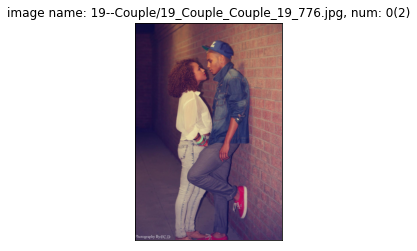

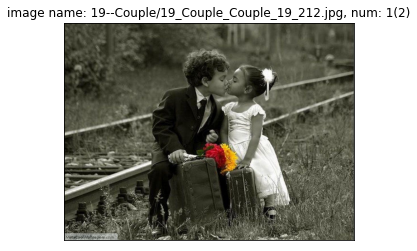

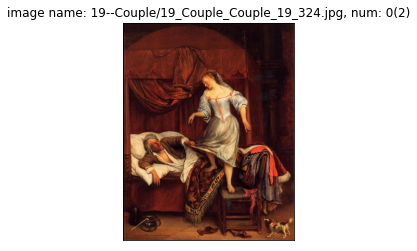

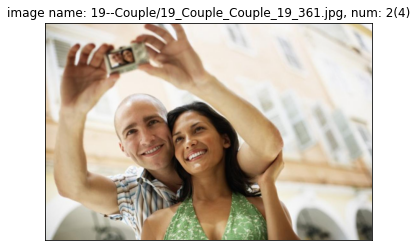

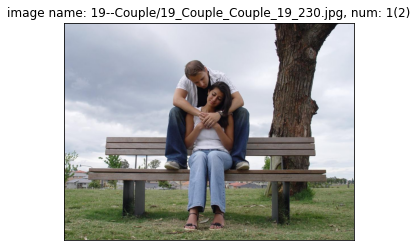

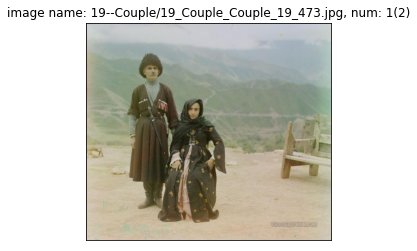

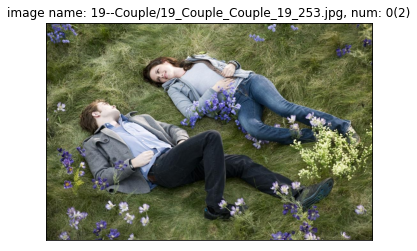

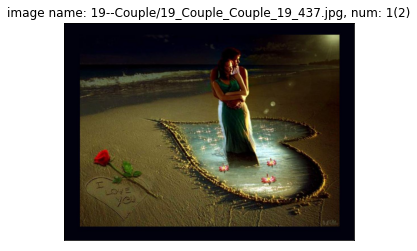

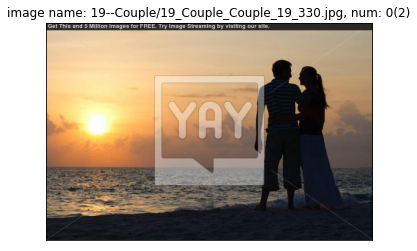

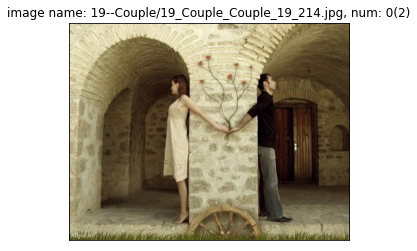

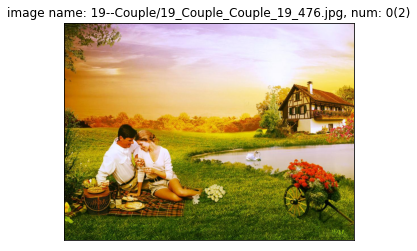

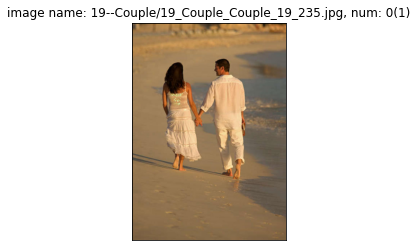

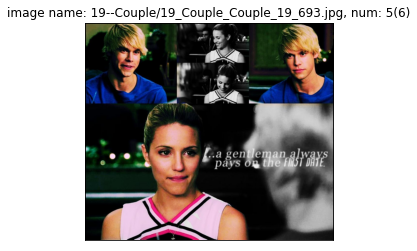

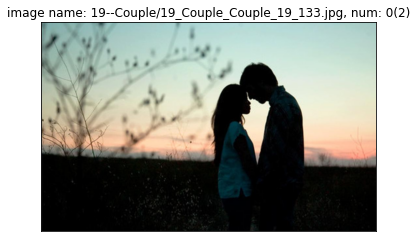

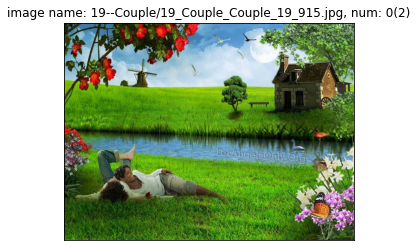

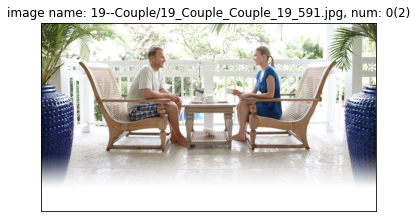

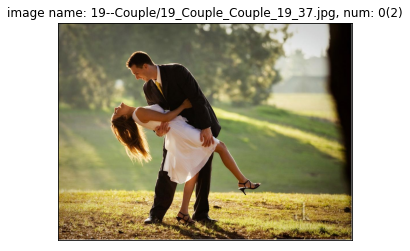

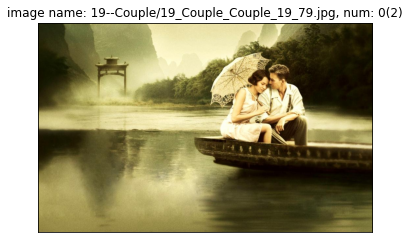

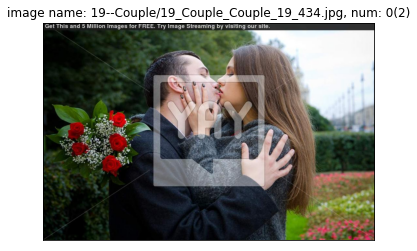

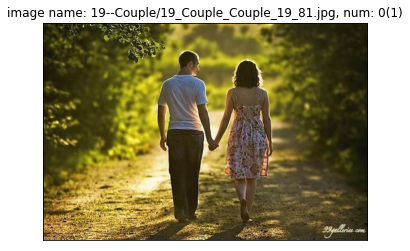

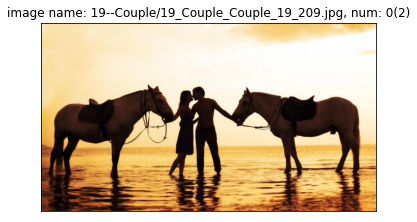

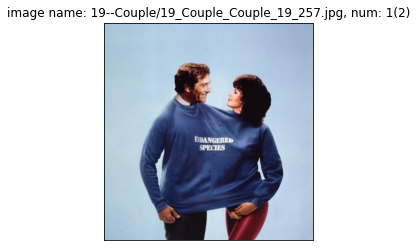

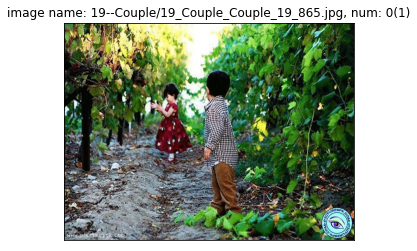

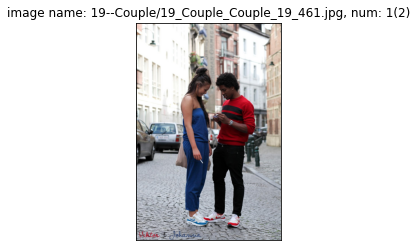

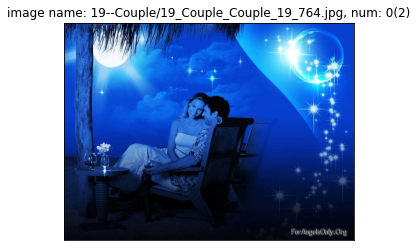

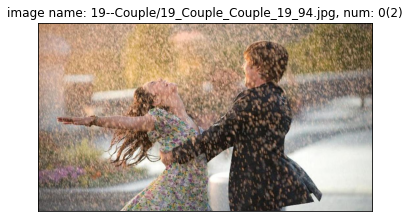

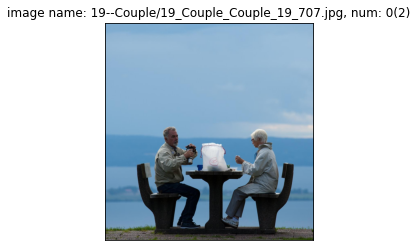

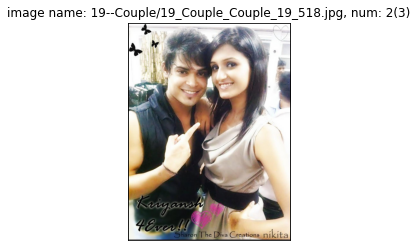

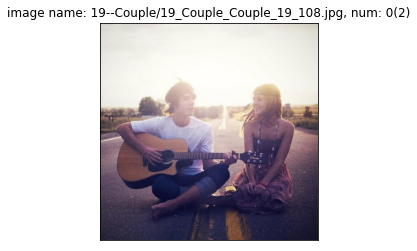

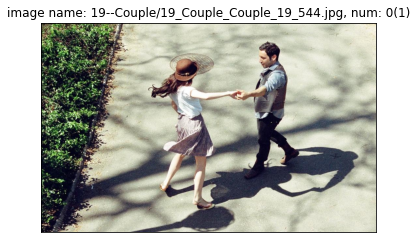

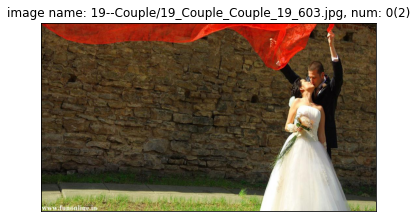

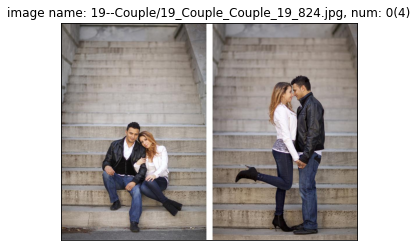

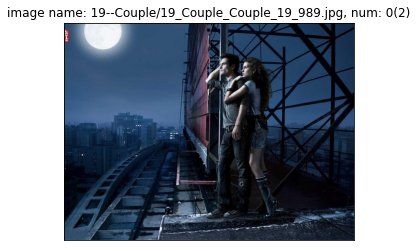

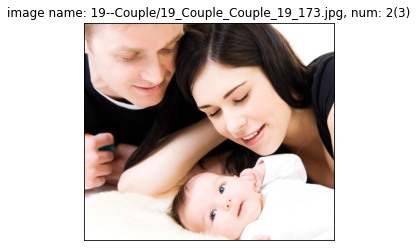

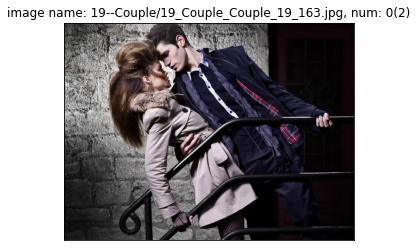

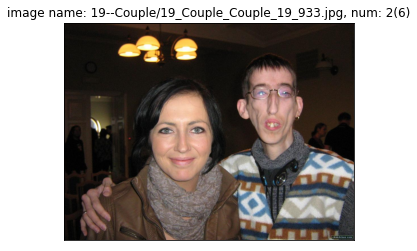

In [275]:
for i in range(0, len(result)):
    if result[i][2] > result[i][3] :
        image = cv2.imread(result[i][0],cv2.IMREAD_COLOR)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        ax = plt.gca()
        ax.axes.xaxis.set_visible(False)
        ax.axes.yaxis.set_visible(False)
        plt.title("image name: {}".format(result[i][0] + ", num: {}".format(result[i][3])) + "({})".format(result[i][2]))
        plt.show()

# Demonstration Dataset

In [276]:
group = "Demonstration"
path = "/Users/thomcope/Documents/ACADEMICS/20 Fall/EECS504/wider_face_split/wider_face_train_bbx_gt.txt" 
data = get_data(group, path)

In [277]:
prototxtPath = "/Users/thomcope/Documents/ACADEMICS/20 Fall/EECS504/deploy.prototxt"
weightsPath = "/Users/thomcope/Documents/ACADEMICS/20 Fall/EECS504/res10_300x300_ssd_iter_140000.caffemodel"
result = tester(data, prototxtPath, weightsPath)

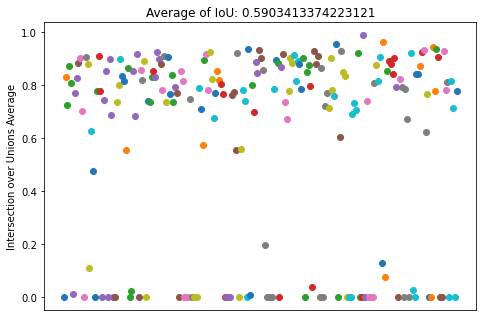

In [278]:
acc = []
for i in range(0, len(result)):
    acc.extend(result[i][1])

acc_arr = np.array(acc)
avg_acc = np.mean(acc_arr)

fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

idx = 0
for i in range(0,len(result)):
    ar = result[i][1] 
    plt.scatter( range(idx, idx+len(ar)) , ar)
    idx = idx + len(ar)



ax.set_title('Average of IoU: {}'.format(avg_acc))
ax.set_ylabel('Intersection over Unions Average')  
ax.axes.xaxis.set_visible(False)
plt.show()

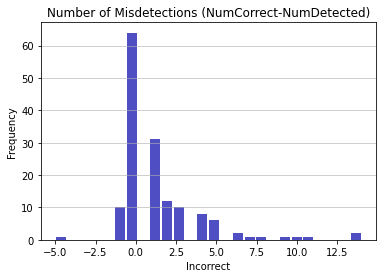

In [279]:
bad = [result[i][2]-result[i][3] for i in range(0, len(result))]

n, bins, patches = plt.hist(x=bad, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Incorrect')
plt.ylabel('Frequency')
plt.title('Number of Misdetections (NumCorrect-NumDetected)')
plt.show()